# Recalibrating the Brunt equation using Eureka data

## Jason Kniss
### Feb 14 2024

This script is used to process the unfiltered code, intended as a test of
functionality and for the author to practice python coding

### Import Libraries

In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
from IPython.display import HTML

### Set path to data folders

separate folders are used because each data source will be treated separately. This is to simplify identification and concatenation.

In [2]:
towermet_path = 'data/eureka-data/tower-met'
towerrad_path = 'data/eureka-data/tower-rad'
bsrnrad_path = 'data/eureka-data/bsrn-rad'

### Crerate lists of dataframes

Loops will generate a list of dataframes from text files added to specified folders.

In [3]:
towermet_dfs = []  # List to store Tower Meteroological dataframes
towerrad_dfs = []  # List to store Tower Radiation dataframes
bsrnrad_dfs = [] # List to store BSRN radiation dataframes

# Import and organize data

### Tower meteorological data

In [4]:
for filename in os.listdir(towermet_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(towermet_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        condition = df['HourMin'] == 2400
        df.loc[condition, 'JulianDay'] += 1
        df.loc[condition, 'HourMin'] = 0000
        #df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        towermet_dfs.append(df)

### Tower radiation data

In [5]:
for filename in os.listdir(towerrad_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(towerrad_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        condition = df['HourMin'] == 2400
        df.loc[condition, 'JulianDay'] += 1
        df.loc[condition, 'HourMin'] = 0000
        #df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        towerrad_dfs.append(df)

### BSRN radiation data
This is redundant of tower radiation data and only serves as a comparison to tower measurements

In [6]:
for filename in os.listdir(bsrnrad_path):
    if filename.endswith(".txt"):  # Only consider .txt files
        file_path = os.path.join(bsrnrad_path, filename)
        with open(file_path, "r") as f:
            lines = f.readlines()

        header = lines[0].strip().split()
        data_rows = [line.strip().split("\t") for line in lines[1:]]

        df = pd.DataFrame(data_rows, columns=header)
        # Rename the dataframe when more data is imported

        df = df.astype('float')
        condition = df['HourMin'] == 2400
        df.loc[condition, 'JulianDay'] += 1
        df.loc[condition, 'HourMin'] = 0000
        #df = df[df['HourMin'] != 2400] # Filter out invalid HourMin values 
        bsrnrad_dfs.append(df)

## Sort and concatenate lists of dataframes

Done separately to simplify concatenation in the next step
### Create datetime columns
### Tower meteorological dataframes

In [7]:
# Create a Datetime column 
for df in towermet_dfs:
    def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
        base_date = datetime(base_year, 1, 1)
        target_date = base_date + timedelta(days=julian_day - 1)
        return target_date.strftime('%Y-%m-%d')

    def hourmin_to_time(hourmin):
        hours = int(hourmin // 100)
        minutes = int(hourmin % 100)
        return f'{hours:02}:{minutes:02}:00'

    # Convert Julian Day to date
    df['Date'] = df['JulianDay'].apply(julian_to_date)

    # Convert HourMin to time   
    df['Time'] = df['HourMin'].apply(hourmin_to_time)

    # Combine date and time into a single datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Drop intermediate columns
    df.drop(columns=['Date', 'Time'], inplace=True)
    
    # Set 'Datetime' column as the index
#    df.set_index('Datetime', inplace=True)

### Tower radiation dataframes

In [8]:
for df in towerrad_dfs:
      def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
          base_date = datetime(base_year, 1, 1)
          target_date = base_date + timedelta(days=julian_day - 1)
          return target_date.strftime('%Y-%m-%d')

      def hourmin_to_time(hourmin):
          hours = int(hourmin // 100)
          minutes = int(hourmin % 100)
          return f'{hours:02}:{minutes:02}:00'

      # Convert Julian Day to date
      df['Date'] = df['JulianDay'].apply(julian_to_date)

      # Convert HourMin to time   
      df['Time'] = df['HourMin'].apply(hourmin_to_time)

      # Combine date and time into a single datetime column
      df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

      # Drop intermediate columns
      df.drop(columns=['Date', 'Time'], inplace=True)
      
      # Set 'Datetime' column as the index
 #     df.set_index('Datetime', inplace=True)

### BSRN radiation dataframes

In [9]:
for df in bsrnrad_dfs:
    def julian_to_date(julian_day, base_year=(df['Year'].iloc[0]).astype('int')):
        base_date = datetime(base_year, 1, 1)
        target_date = base_date + timedelta(days=julian_day - 1)
        return target_date.strftime('%Y-%m-%d')

    def hourmin_to_time(hourmin):
        hours = int(hourmin // 100)
        minutes = int(hourmin % 100)
        return f'{hours:02}:{minutes:02}:00'

    # Convert Julian Day to date
    df['Date'] = df['JulianDay'].apply(julian_to_date)

    # Convert HourMin to time   
    df['Time'] = df['HourMin'].apply(hourmin_to_time)

    # Combine date and time into a single datetime column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

    # Drop intermediate columns
    df.drop(columns=['Date', 'Time'], inplace=True)

### Concatenate lists of dataframes into dataframes and reindex by datetime

In [10]:
# Concatenate vertically
towermet_df = pd.concat(towermet_dfs, ignore_index=True)
towerrad_df = pd.concat(towerrad_dfs, ignore_index=True)
bsrnrad_df = pd.concat(bsrnrad_dfs, ignore_index=True)

# Sort by datetime column
towermet_df.sort_values(by='Datetime', inplace=True)    
towerrad_df.sort_values(by='Datetime', inplace=True)  
bsrnrad_df.sort_values(by='Datetime', inplace=True)

# Set 'Datetime' column as the index
towermet_df.set_index('Datetime', inplace=True)
towerrad_df.set_index('Datetime', inplace=True)
bsrnrad_df.set_index('Datetime', inplace=True)

### Join dataframes into one dataframe with pertinant columns

In [11]:
towermet_df_select = towermet_df[['Pressure[mbar]', '10MRH[%]', '6MRH[%]', '2MRH[%]', '10MTair[degC]', '6MTair[degC]', '2MTair[degC]']]
towerrad_df_select = towerrad_df[['LWTotalDownwelling[W/m^2]']]
bsrnrad_df_select = bsrnrad_df[['LWTotalDownwelling[W/m^2]']].copy()
bsrnrad_df_select.rename(columns={'LWTotalDownwelling[W/m^2]': 'bsrnLWTotalDownwelling[W/m^2]'}, inplace=True)

target_df = towermet_df_select.join(towerrad_df_select, how='outer').join(bsrnrad_df_select, how='outer')

In [32]:
target_df.head()

,Pressure[mbar],10MRH[%],6MRH[%],2MRH[%],10MTair[degC],6MTair[degC],2MTair[degC],LWTotalDownwelling[W/m^2],bsrnLWTotalDownwelling[W/m^2]
Datetime,,,,,,,,,
2011-05-15 00:00:00,1012.4,73.746,74.090,73.352,-13.795,-13.755,-13.788,178.499,NaN
2011-05-15 00:01:00,1012.4,74.163,74.231,73.576,-13.874,-13.806,-13.841,178.370,176.84
2011-05-15 00:02:00,1012.4,74.178,74.602,73.994,-13.957,-13.887,-13.920,178.464,178.26
2011-05-15 00:03:00,1012.4,73.599,74.417,74.503,-13.897,-13.877,-13.874,178.586,178.67
2011-05-15 00:04:00,1012.4,73.317,74.186,74.604,-13.831,-13.823,-13.806,178.583,178.49


In [33]:
target_df.describe()

,Pressure[mbar],10MRH[%],6MRH[%],2MRH[%],10MTair[degC],6MTair[degC],2MTair[degC],LWTotalDownwelling[W/m^2],bsrnLWTotalDownwelling[W/m^2]
count,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,11520.000000,8642.000000
mean,1009.673885,60.938048,61.045173,61.266068,-0.253145,-0.299319,-0.425323,252.007745,226.791844
std,8.356647,16.629128,16.481022,16.737523,10.603025,10.693661,10.732160,65.841121,160.631852
min,996.910000,16.836000,17.281000,17.614000,-15.671000,-15.995000,-15.920000,171.492000,-9999.000000
25%,1003.200000,52.758750,53.465000,52.950250,-7.963175,-8.227375,-8.273650,196.199000,186.070000
50%,1007.800000,67.516500,67.284500,67.944000,-3.618850,-3.620850,-3.872500,242.630000,236.090000
75%,1015.025000,72.117000,72.175500,72.869250,8.389975,8.378200,8.445450,288.113250,271.120000
max,1023.600000,86.036000,86.253000,86.084000,19.754000,19.998000,19.825000,416.329000,289.120000


In [34]:
target_df.columns

Index(['Pressure[mbar]', '10MRH[%]', '6MRH[%]', '2MRH[%]', '10MTair[degC]',
       '6MTair[degC]', '2MTair[degC]', 'LWTotalDownwelling[W/m^2]',
       'bsrnLWTotalDownwelling[W/m^2]'],
      dtype='object')

In [35]:
target_df.index

DatetimeIndex(['2011-05-15 00:00:00', '2011-05-15 00:01:00',
               '2011-05-15 00:02:00', '2011-05-15 00:03:00',
               '2011-05-15 00:04:00', '2011-05-15 00:05:00',
               '2011-05-15 00:06:00', '2011-05-15 00:07:00',
               '2011-05-15 00:08:00', '2011-05-15 00:09:00',
               ...
               '2014-07-04 23:51:00', '2014-07-04 23:52:00',
               '2014-07-04 23:53:00', '2014-07-04 23:54:00',
               '2014-07-04 23:55:00', '2014-07-04 23:56:00',
               '2014-07-04 23:57:00', '2014-07-04 23:58:00',
               '2014-07-04 23:59:00', '2014-07-05 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=11526, freq=None)

## 1) Calculate effective emissivity

### Calculate effective emissivity from measured DLR and Temperature

In [12]:
SIGMA = 5.67e-8

In [13]:
# Convert temperature from Celsius to Kelvin

towermet_df['T2_K'] = towermet_df['2MTair[degC]'] + 273.15 
towermet_df['T6_K'] = towermet_df['6MTair[degC]'] + 273.15 
towermet_df['T10_K'] = towermet_df['10MTair[degC]'] + 273.15 

# Calculate effective emissivity
towermet_df['eps2'] = towerrad_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * towermet_df['T2_K']**4)
towermet_df['eps6'] = towerrad_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * towermet_df['T6_K']**4)
towermet_df['eps10'] = towerrad_df['LWTotalDownwelling[W/m^2]'] / (SIGMA * towermet_df['T10_K']**4)

## 2) Calculate expected DLR 

*This step will come after fitting a power curve to the measured DLR data*

Calculate Partial Pressure of water vapor (hPa)

In [14]:
towermet_df['Pw2'] = 610.94*(towermet_df['2MRH[%]']/100)*np.exp((17.625*(towermet_df['T2_K'] - 273.15))/(towermet_df['T2_K'] - 30.11))/100
towermet_df['Pw6'] = 610.94*(towermet_df['6MRH[%]']/100)*np.exp((17.625*(towermet_df['T6_K'] - 273.15))/(towermet_df['T6_K'] - 30.11))/100
towermet_df['Pw10'] = 610.94*(towermet_df['10MRH[%]']/100)*np.exp((17.625*(towermet_df['T10_K'] - 273.15))/(towermet_df['T10_K'] - 30.11))/100

Calculate clear sky emissivity
*Parameters per the original Brunt equation. **Don't Run both emissivity cells***

In [15]:
towermet_df['e2'] = (0.52 + 0.065*np.sqrt(towermet_df['Pw2']))
towermet_df['e6'] = (0.52 + 0.065*np.sqrt(towermet_df['Pw6']))
towermet_df['e10'] = (0.52 + 0.065*np.sqrt(towermet_df['Pw10']))

Calculate clear sky emissivity
*Calibrated parameters per Li et al. 2017. **Don't Run both emissivity cells***

In [16]:
# towermet_df['e2'] = (0.618 + 0.054*np.sqrt(towermet_df['Pw2']))
# towermet_df['e6'] = (0.618 + 0.054*np.sqrt(towermet_df['Pw6']))
# towermet_df['e10'] = (0.618 + 0.054*np.sqrt(towermet_df['Pw10']))

Calculate expected DLR

In [17]:
towermet_df['DLR2'] = towermet_df['e2']*SIGMA*(towermet_df['T2_K']**4)
towermet_df['DLR6'] = towermet_df['e6']*SIGMA*(towermet_df['T6_K']**4)
towermet_df['DLR10'] = towermet_df['e10']*SIGMA*(towermet_df['T10_K']**4)

Create a mask to filter out NaN values

In [18]:
epsmask2 = towermet_df['eps2'].notna()
epsmask6 = towermet_df['eps6'].notna()
epsmask10 = towermet_df['eps10'].notna()
DLRmask2 = towermet_df['DLR2'].notna() & towerrad_df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask6 = towermet_df['DLR6'].notna() & towerrad_df['LWTotalDownwelling[W/m^2]'].notna()
DLRmask10 = towermet_df['DLR10'].notna() & towerrad_df['LWTotalDownwelling[W/m^2]'].notna()

## 3) Generate Plots

### Emissivity over Time
*Does not work for short selections of data spanning years*

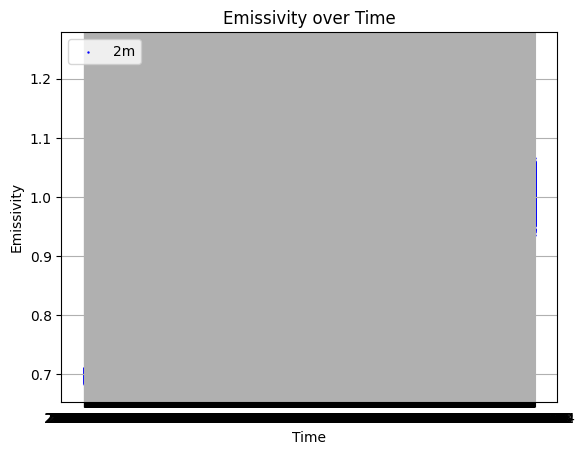

In [22]:
## Plot e_sky over time
plt.scatter(towermet_df.index[epsmask2], towermet_df['eps2'][epsmask2], label='2m', s=0.5, color='blue')
# plt.scatter(towermet_df.index[epsmask6], towermet_df['eps6'][epsmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towermet_df.index[epsmask10], towermet_df['eps10'][epsmask10], label='10m', s=0.5, color='red')

# Set ticks at regular intervals
# Find the start and end dates in your DataFrame
start_date = towermet_df.index.min()
end_date = towermet_df.index.max()

# # Generate ticks at regular intervals between start and end dates
ticks = pd.date_range(start=start_date, end=end_date, freq='12h')
tick_labels = [date.strftime('%Y-%m-%d') if i % 4 == 0 else None for i, date in enumerate(ticks)]

# Format the plot
plt.xticks(ticks, tick_labels)
plt.xlabel('Time')
plt.ylabel('Emissivity')
plt.title('Emissivity over Time')
plt.legend()
plt.grid()

# Save plot as .png
# plt.savefig('emissivity.png')

### Expected vs Measured DLR

Axis start at zero

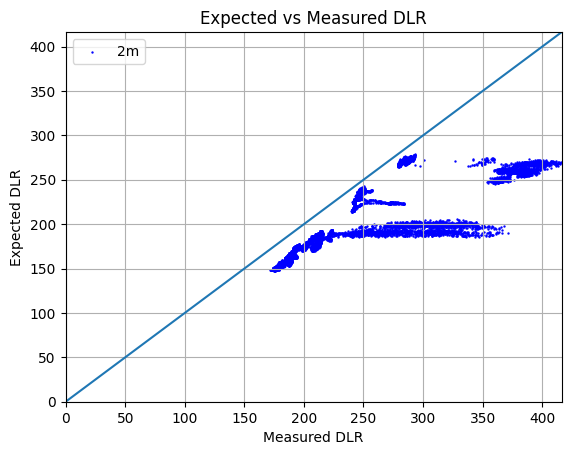

In [23]:
## Plot expected DLR vs measured DLR
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2], towermet_df['DLR2'][DLRmask2], label='2m', s=0.5, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(towermet_df['DLR2'][DLRmask2]))
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.grid()
plt.plot([0,max_value],[0,max_value])

# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')

### Expected vs Measured DLR

Grid fitted to data (i.e. zoomed in)

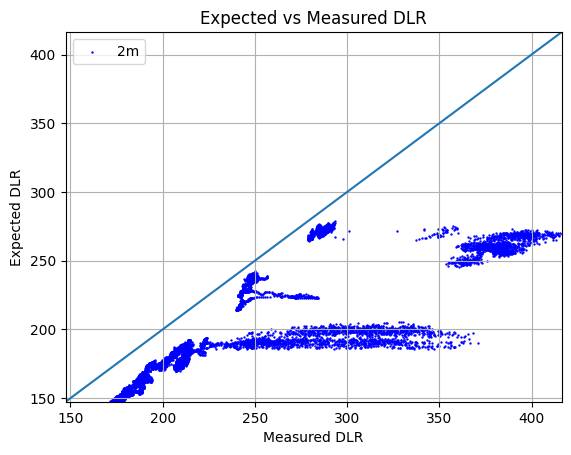

In [24]:
## Plot expected DLR vs measured DLR
plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2], towermet_df['DLR2'][DLRmask2], label='2m', s=0.5, color='blue')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask6], towermet_df['DLR6'][DLRmask6], label='6m', s=0.5, color='cyan')
# plt.scatter(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask10], towermet_df['DLR10'][DLRmask10], label='10m', s=0.5, color='red')

# Calculate the maximum value for x and y
max_value = max(np.nanmax(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmax(towermet_df['DLR2'][DLRmask2]))
min_value = min(np.nanmin(towerrad_df['LWTotalDownwelling[W/m^2]'][DLRmask2]), np.nanmin(towermet_df['DLR2'][DLRmask2]))
plt.xlim(min_value, max_value)
plt.ylim(min_value, max_value)
plt.grid()
plt.plot([min_value,max_value],[min_value,max_value])


# Format the plot
plt.xlabel('Measured DLR')
plt.ylabel('Expected DLR')
plt.title('Expected vs Measured DLR')
plt.legend()

# Save plot as .png
# plt.savefig('exp-vs-measured-DLR.png')